## Import libs, set paths and load params

In [18]:
import os
import numpy as np
import pandas as pd
import sys
import csv
sys.path.insert(0, "../src")
ART_NET_PATH = "../networks"

import auxilary_functions as f
from generation_algorithm import *
from copy import deepcopy
import networkx as nx
from time import sleep
import statistics
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Yeast Tnet and select the FFL-based component

In [19]:
interaction_matrix = f.get_interaction_matrix(cfg)

%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

# Vertex-based motif network on FFL
motifs_network = f.build_vmn(motifs_orig, verbose=True)
V = nx.Graph(motifs_network)
nx.is_connected(V)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


100%|██████████| 5676765/5676765 [00:15<00:00, 363568.43it/s]


True

## Topology stats

In [22]:
def collect_topology_stats(growth_pace_vec, matrix_size_vec, initial_size_vec):
    network_topology_stats = {}
    #import resource
    
    for growth_pace_num in growth_pace_vec:
        for final_size in matrix_size_vec:
            for initial_size in initial_size_vec:
                
                #generate network
                artificial_matrix_ffl = generate_artificial_network(
                    interaction_matrix, motifs=motifs_orig, motifs_network=motifs_network,
                    nucleus_size=initial_size, network_size=final_size, growth_pace=growth_pace_num,
                    reference_matrix=interaction_matrix_ffl)
                
                sparsity = artificial_matrix_ffl[2]
                time_spent = artificial_matrix_ffl[1]
                artificial_matrix_ffl = artificial_matrix_ffl[0]
                
                #GS-to-Networkx format conversion
                art_matrix = artificial_matrix_ffl.transpose()

                if not os.path.exists(ART_NET_PATH):
                        os.mkdir(ART_NET_PATH)
                joblib.dump(
                        art_matrix, os.path.join(ART_NET_PATH,'_'+f"test{art_matrix.shape[0]}.gz")

                )

                #create edgelist
                D1 = nx.DiGraph(art_matrix)
                nx.write_edgelist(D1, os.path.join(ART_NET_PATH, "test.tsv"), data=False)

                #analyze network
                network_test = f.read_df_as_network(os.path.join(ART_NET_PATH, "test.tsv"))
                diameter = nx.diameter(network_test)
                shortest_path = nx.average_shortest_path_length(network_test)
                
                #collect stats
                key_to_dic = '_'.join(str(x) for x in [final_size,initial_size,growth_pace_num])
                list_with_stats = [growth_pace_num, final_size, initial_size, sparsity,
                                   np.round(shortest_path, 4), diameter, time_spent]
                network_topology_stats[key_to_dic] = list_with_stats

    return network_topology_stats

In [23]:
dict_with_stats = collect_topology_stats([0.6],[100],[25])

Nucleus matrix shape: (25, 25)



Network has been successfully generated!
Total time spent: 0:00:16.450680


In [24]:
list_with_stats = list(dict_with_stats.values())
csv_columns = ['growth_pace','size','nucleus_size', 'sparsity', 'shortest_path', 'diameter', 'time_spent']
list_with_stats.insert(0,csv_columns)

with open("../networks/topology_stats.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(list_with_stats)

In [25]:
topology_data = pd.read_csv("../networks/topology_stats.csv",header=0, delimiter=",")
topology_data

,growth_pace,size,nucleus_size,sparsity,shortest_path,diameter,time_spent
0,0.6,100,25,2.67,2.1509,3,0:00:16.450626


In [ ]:
topology_data['shortest_path'].plot(kind='bar')

## Visualize network

In [26]:
def read_df_as_network(filename):
    with open(filename, 'rt') as f:
        network_df = pd.read_csv(f, sep=' ', header = None)
        network = nx.from_pandas_edgelist(network_df, create_using=nx.DiGraph(), source = 0, target = 1)
        return network
    
network_test = read_df_as_network(os.path.join(ART_NET_PATH, "test.tsv"))

In [28]:
network_test.out_degree()

OutDegreeView({1: 28, 0: 0, 2: 59, 3: 48, 5: 16, 11: 0, 15: 12, 20: 0, 24: 25, 25: 0, 27: 0, 28: 0, 31: 0, 34: 0, 35: 10, 38: 0, 41: 7, 42: 0, 48: 0, 58: 1, 61: 0, 63: 0, 64: 0, 66: 0, 74: 1, 77: 0, 93: 0, 95: 0, 99: 0, 4: 0, 7: 0, 8: 0, 9: 7, 10: 0, 14: 0, 16: 0, 19: 8, 21: 0, 23: 0, 26: 0, 29: 0, 33: 0, 39: 0, 40: 0, 43: 0, 44: 0, 46: 1, 49: 0, 52: 2, 57: 0, 60: 0, 62: 0, 68: 1, 75: 1, 76: 0, 80: 0, 81: 1, 84: 0, 85: 1, 86: 0, 87: 0, 88: 0, 89: 0, 94: 0, 96: 0, 98: 0, 6: 0, 17: 0, 18: 0, 22: 1, 32: 1, 37: 0, 47: 0, 50: 0, 54: 1, 55: 0, 65: 0, 67: 2, 72: 0, 79: 0, 82: 0, 83: 0, 90: 0, 91: 0, 92: 0, 30: 2, 53: 2, 73: 0, 12: 2, 13: 6, 71: 0, 78: 0, 97: 1, 36: 7, 69: 3, 45: 2, 51: 2, 56: 2, 59: 2, 70: 2})

### Network

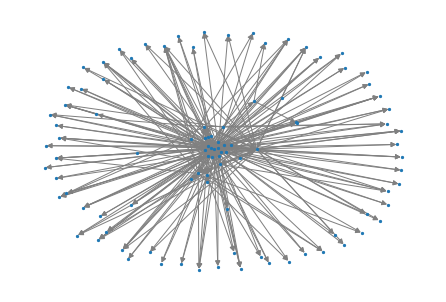

In [29]:
nx.draw(network_test, node_size = 5, edge_color = 'gray')

### Minimum spanning tree

In [ ]:
tree = nx.minimum_spanning_tree(network_test)
nx.draw(tree, node_size = 5, edge_color = 'gray')

In [ ]:
nx.diameter(network_test)

In [ ]:
nx.average_shortest_path_length(network_test)

In [ ]:
degrees = [network_test.degree(n) for n in network_test.nodes()]
print(statistics.median(degrees))

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
network_test = [d for n, d in network_test.degree]
plt.hist(network_test, bins=100, alpha=0.75)